<a href="https://colab.research.google.com/github//s4ysolutions//whisper-s4y/blob/main/colab/whisper_tflite_s4y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the demo for [whisper-s4y](https://github.com/s4ysolutions/whisper-s4y/tree/main)

## Data preparation

In [ ]:
!pip install git+https://github.com/s4ysolutions/whisper-s4y

  Cloning https://github.com/s4ysolutions/whisper-s4y to /tmp/pip-req-build-tlmker7u
  Running command git clone --filter=blob:none --quiet https://github.com/s4ysolutions/whisper-s4y /tmp/pip-req-build-tlmker7u
  Resolved https://github.com/s4ysolutions/whisper-s4y to commit e4bef88943c00e7c2b111738c1c79caa809d16b7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


Library

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import whisper_s4y.whisper.huggingface as hf

test_model_id = 'openai/whisper-tiny'

from matplotlib.axes import Axes

def normalized_audio_from_wav(wav_file_path) -> tf.TensorSpec(shape=[480000], dtype=tf.float32):
    if not os.path.isabs(wav_file_path):
        wav_file_path = os.path.join('.', wav_file_path)
    waveform, sample_rate = tf.audio.decode_wav(tf.io.read_file(wav_file_path))
    if sample_rate != 16000:
        waveform = tfio.audio.resample(waveform, rate_in=sample_rate, rate_out=16000)
    audio = waveform[:, 0]
    size = audio.shape[0]
    if size < 480000:
        audio = tf.concat([audio, tf.zeros(480000 - size)], 0)
    elif size > 480000:
        audio = audio[:480000]
    return audio

def _plot_logmel(logmel: tf.TensorSpec(shape=[80, 3000], dtype=tf.float32), fig, ax: Axes, title: str = 'LogMel'):
    # cax = ax.imshow(tf.transpose(logmel), aspect='auto', origin='lower', cmap='viridis')
    cax = ax.imshow(logmel, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(cax, ax=ax, label='Magnitude')
    ax.set_title(title)
    ax.set_ylabel('Frequency bin')
    ax.set_xlabel('Time frame')


def _plot_output(logmel: tf.TensorSpec(shape=[1500, 384], dtype=tf.float32), fig, ax: Axes,
                 title: str = 'Encoded output'):
    # cax = ax.imshow(tf.transpose(logmel), aspect='auto', origin='lower', cmap='viridis')
    cax = ax.imshow(logmel, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(cax, ax=ax, label='Value')
    ax.set_title(title)
    ax.set_ylabel('Frames')
    ax.set_xlabel('Embeddings')


def plot_input_features(features_transformers: tf.TensorSpec(shape=[1, 80, 30000], dtype=tf.float32),
                        features_under_test: tf.TensorSpec(shape=[1, 80, 3000], dtype=tf.float32), title):
    fig1, axs1 = plt.subplots(2, 1, figsize=(12, 12))  # Create a figure containing a single Axes.
    fig1.canvas.manager.set_window_title(f"Test: {title}")
    fig1.suptitle(f"Test: {title}")
    _plot_logmel(features_under_test[0], fig1, axs1[0], f"LogMel (under test)")
    _plot_logmel(features_transformers[0], fig1, axs1[1], f"LogMel (transformers)")
    plt.show()


def plot_diff(tf1: tf.TensorSpec(shape=None, dtype=tf.float32), tf2: tf.TensorSpec(shape=None, dtype=tf.float32),
              title):
    tf0 = tf1 - tf2
    fig1, ax = plt.subplots(1, 1, figsize=(12, 12))  # Create a figure containing a single Axes.
    fig1.canvas.manager.set_window_title(f"Test: {title}")
    fig1.suptitle(f"Test: {title}")
    cax = ax.imshow(tf0, aspect='auto', origin='lower', cmap='viridis')
    fig1.colorbar(cax, ax=ax, label='Magnitude')

#plot_diff(tf.constant([1, 2, 3, 4, 5], dtype=tf.float32), tf.constant([5, 4, 3, 2, 1], dtype=tf.float32), "test")

def plot_encoded_output(output_transformers: tf.TensorSpec(shape=[1, 1500, 384], dtype=tf.float32),
                        output_under_test: tf.TensorSpec(shape=[1, 1500, 384], dtype=tf.float32), title):
    fig1, axs1 = plt.subplots(2, 1, figsize=(12, 12))  # Create a figure containing a single Axes.
    fig1.canvas.manager.set_window_title(f"Test: {title}")
    fig1.suptitle(f"Test: {title}")
    _plot_output(output_under_test[0], fig1, axs1[0], f"Encoded output (under test)")
    _plot_output(output_transformers[0], fig1, axs1[1], f"Encoded output (transformers)")
    plt.show()

def transformers_input_features(audio: tf.TensorSpec(shape=[480000], dtype=tf.float32),
                                huggingface_model_id: str = test_model_id) -> tf.TensorSpec(shape=[1, 80, 3000],
                                                                                            dtype=tf.float32):
    feature_extractor = hf.feature_extractor(huggingface_model_id)
    return feature_extractor(audio, sampling_rate=16000, return_tensors="tf")["input_features"]

def transformers_encoded_output(input_features: tf.TensorSpec(shape=[1, 80, 3000], dtype=tf.float32),
                                huggingface_model_id: str = test_model_id) -> tf.TensorSpec(
    shape=[1, 5000, 384],
    dtype=tf.float32):
    encoder = hf.encoder(huggingface_model_id)
    output = encoder(input_features)
    return output.last_hidden_state


In [ ]:
transformers_feature_extractor = hf.feature_extractor(test_model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
import requests

url = 'https://firebasestorage.googleapis.com/v0/b/mldemo-b838e.appspot.com/o/colab%2FOSR_us_000_0030_16k.wav?alt=media&token=36976bd2-7e5c-40a4-ae92-a77cb31eed1c'
response = requests.get(url)

# Save the file to disk
with open('OSR_us_000_0030_16k.wav', 'wb') as file:
    file.write(response.content)

print("File downloaded successfully!")

File downloaded successfully!


In [ ]:
from IPython.display import Audio

# Replace 'path_to_your_wav_file.wav' with the correct file path
Audio('OSR_us_000_0030_16k.wav')

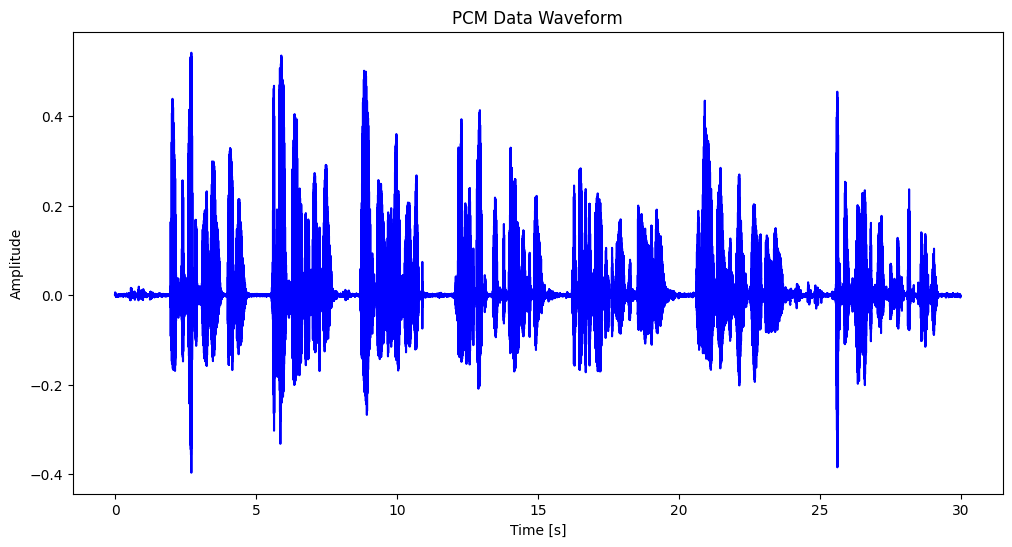

In [ ]:
waveform = normalized_audio_from_wav("OSR_us_000_0030_16k.wav")

time_axis = np.linspace(0, len(waveform) / 16000, num=len(waveform))
plt.figure(figsize=(12, 6))
plt.plot(time_axis, waveform, color='blue')
plt.title('PCM Data Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

## Pipeline

### Features extraction (LogMel)

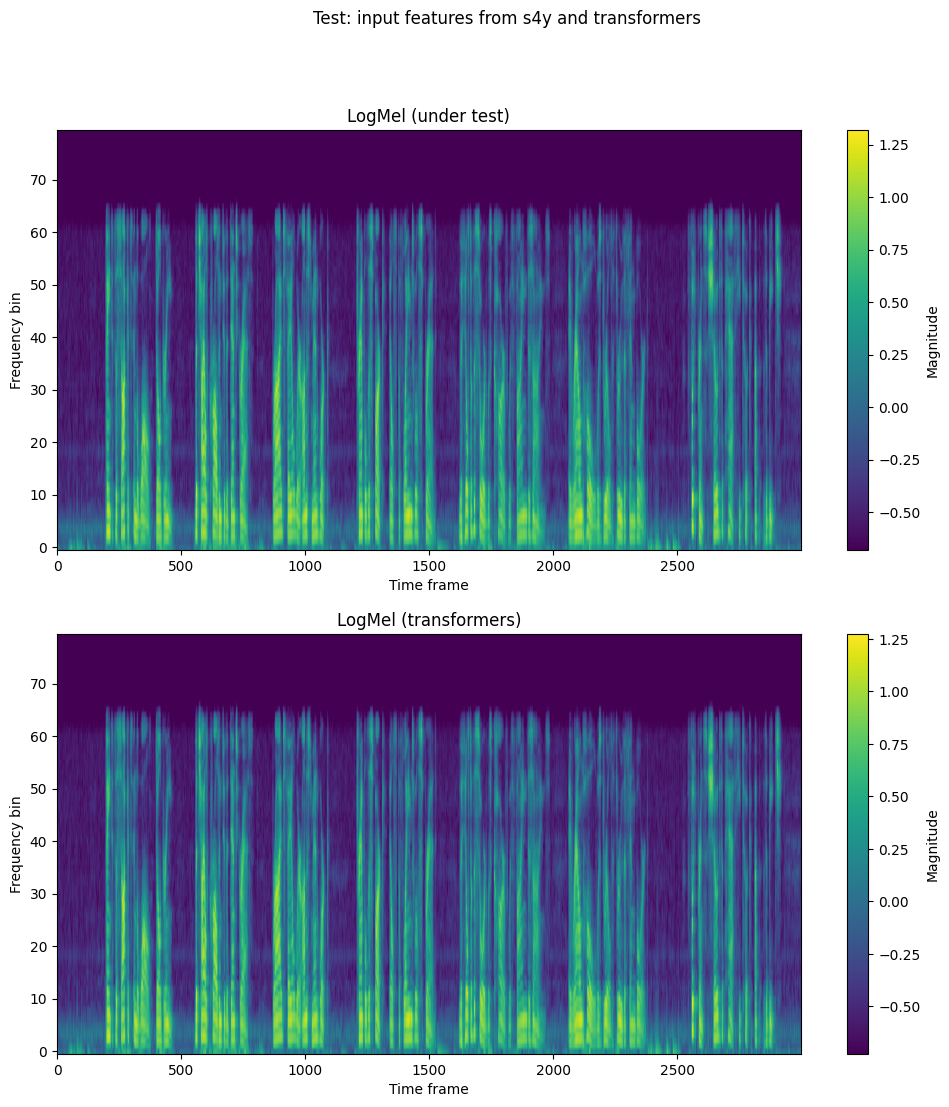

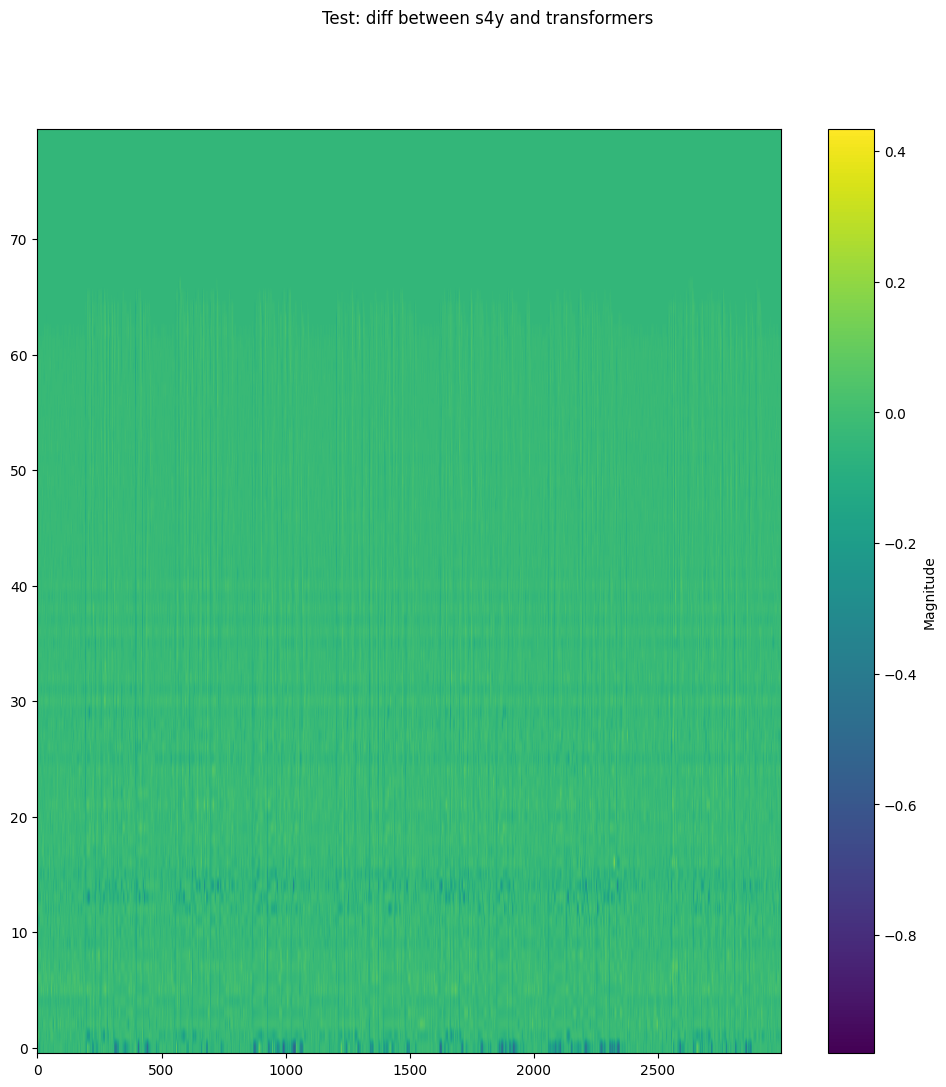

In [ ]:
from whisper_s4y.features_extractor import S4yFeaturesExtractor

features_extractor = S4yFeaturesExtractor()
input_features = features_extractor(waveform)

assert input_features.shape == (1, 80, 3000)
assert input_features.dtype == tf.float32

oif = input_features[:, :, :-1]
transformers_input_features= transformers_feature_extractor(waveform, sampling_rate=16000, return_tensors="tf")["input_features"]
tif = transformers_input_features[:, :, 1:]
plot_input_features(tif, oif, "input features from s4y and transformers")
plot_diff(tif[0], oif[0], "diff between s4y and transformers")

### Encoder (openai/whisper-tiny)

In [ ]:
from whisper_s4y.whisper.huggingface.s4y_model import S4yEncoder

encoder=S4yEncoder(test_model_id)

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/151M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFWhisperForConditionalGeneration.

All the weights of TFWhisperForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFWhisperForConditionalGeneration for predictions without further training.


All PyTorch model weights were used when initializing TFWhisperForConditionalGeneration.

All the weights of TFWhisperForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFWhisperForConditionalGeneration for predictions without further training.


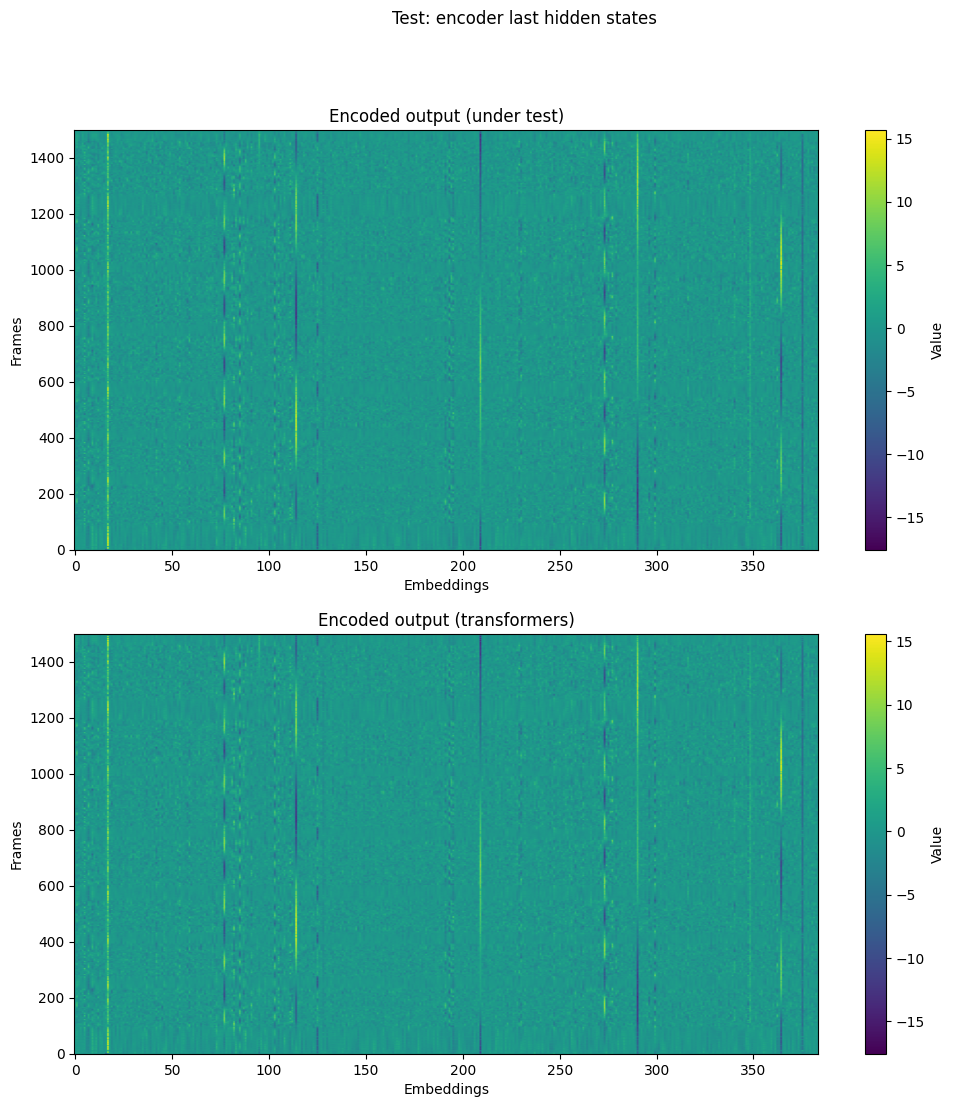

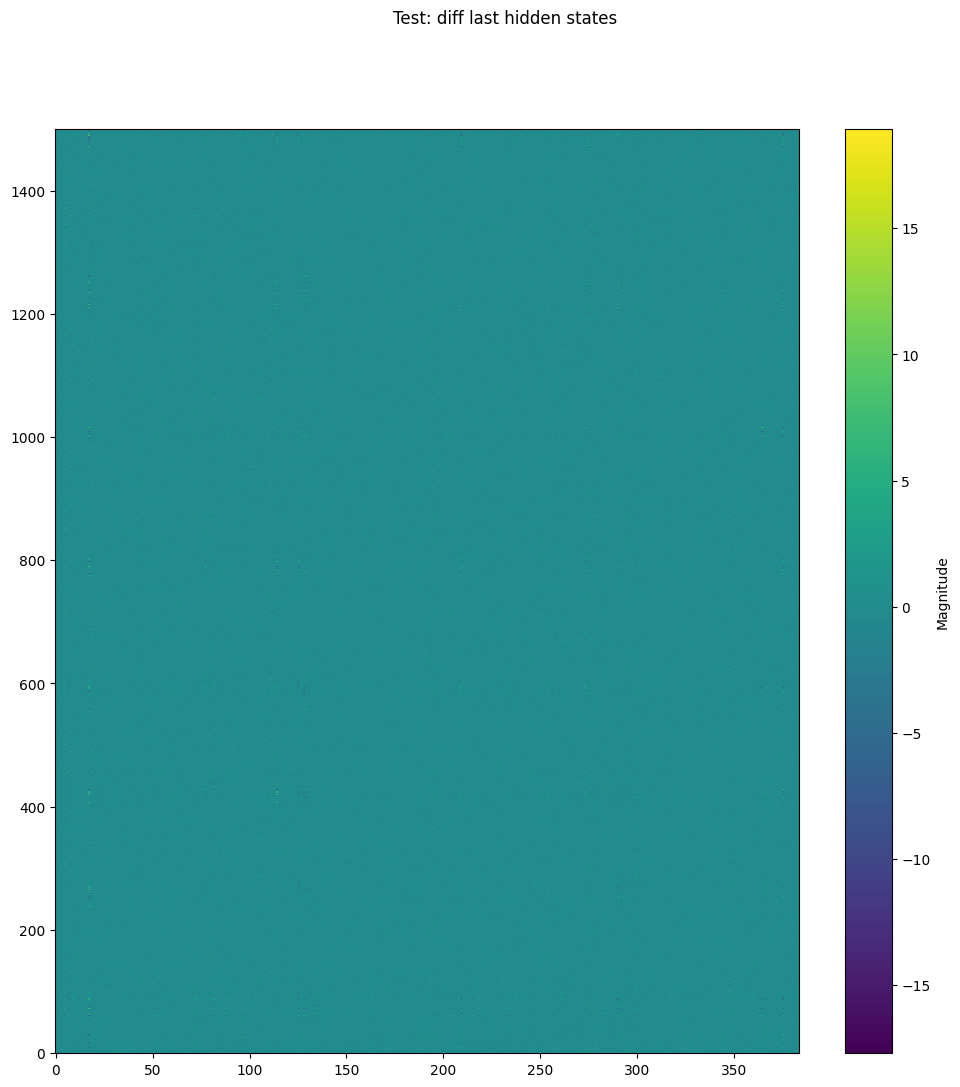

In [ ]:
encoded = encoder(input_features)
encoded_last_hidden_state = encoded.last_hidden_state
transformers_encoded_last_hidden_state = transformers_encoded_output(transformers_input_features)
plot_encoded_output(transformers_encoded_last_hidden_state, encoded_last_hidden_state, "encoder last hidden states")
plot_diff(transformers_encoded_last_hidden_state[0], encoded_last_hidden_state[0], "diff last hidden states")

### Decoder

In [ ]:
from whisper_s4y.whisper.huggingface.s4y_model import S4yDecoder

decoder=S4yDecoder(test_model_id, lang='en', max_length=200)

tokens = decoder(encoder_hidden_states=encoded_last_hidden_state)
print(tokens)

All PyTorch model weights were used when initializing TFWhisperForConditionalGeneration.

All the weights of TFWhisperForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFWhisperForConditionalGeneration for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tf.Tensor(
[[50258 50259 50359 50363 34865   264   370 11984   294   264  2929    11
  23471  3092    13   440  1440 13999  1493   666   264 18011  8054    11
    272  2024   279  3061   689  3245  1706   589    13  1765  1215   304
    264  9908    11  1646   264 23743   486  3974    13   440   276  2352
    295   264 10576   390 28613   365  2489 11347    13   316  3098  5458
    390 38210   807   264  5862  3150    13 20989 25788  4712   264  3100
    415  1890   493   264  7534    13 50257]], shape=(1, 79), dtype=int32)


### Postprocessing

In [ ]:
tokenizer = hf.tokenizer(test_model_id)
print(tokenizer.decode(tokens[0]))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<|startoftranscript|><|en|><|transcribe|><|notimestamps|> Paint the sockets in the wall, dull green. The child crawled into the dense grass, bribes fail where honest men work. Trampal the spark, else the flames will spread. The hilt of the sword was carved with fine designs. A round hole was drilled through the thin board. Footprints showed the path he took up the beach.<|endoftext|>


## TFLite

Create unoptimized TF Lite models S4yPcmEncoder in order to keep precise

In [ ]:
from whisper_s4y.whisper.huggingface.s4y_model import S4yPcmEncoder, S4yDecoder

tflite_model_path = S4yPcmEncoder(test_model_id).tflite(optimize=False)
s4y_pcm_encoder_interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
s4y_pcm_encoder_runner = s4y_pcm_encoder_interpreter.get_signature_runner()

All PyTorch model weights were used when initializing TFWhisperForConditionalGeneration.

All the weights of TFWhisperForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFWhisperForConditionalGeneration for predictions without further training.


whisper_s4y 2024-08-26 20:14:38,943 DEBUG pcm-encoder save start...


DEBUG:whisper_s4y:pcm-encoder save start...


whisper_s4y 2024-08-26 20:14:46,626 INFO pcm-encoder save done in  /tmp/whisper2tflite/pcm-encoder


INFO:whisper_s4y:pcm-encoder save done in  /tmp/whisper2tflite/pcm-encoder


whisper_s4y 2024-08-26 20:14:46,632 INFO pcm-encoder.tflite create converter start...


INFO:whisper_s4y:pcm-encoder.tflite create converter start...


whisper_s4y 2024-08-26 20:14:48,240 INFO pcm-encoder.tflite create converter done


INFO:whisper_s4y:pcm-encoder.tflite create converter done


whisper_s4y 2024-08-26 20:14:48,248 INFO pcm-encoder.tflite converting start...


INFO:whisper_s4y:pcm-encoder.tflite converting start...


whisper_s4y 2024-08-26 20:14:49,913 INFO pcm-encoder.tflite converting done


INFO:whisper_s4y:pcm-encoder.tflite converting done


whisper_s4y 2024-08-26 20:14:49,918 DEBUG pcm-encoder.tflite converted model save start...


DEBUG:whisper_s4y:pcm-encoder.tflite converted model save start...


whisper_s4y 2024-08-26 20:14:49,988 INFO pcm-encoder.tflite converted model save done: /usr/local/lib/python3.10/dist-packages/artefacts/pcm-encoder.tflite


INFO:whisper_s4y:pcm-encoder.tflite converted model save done: /usr/local/lib/python3.10/dist-packages/artefacts/pcm-encoder.tflite


Create optimized TF Lite models S4yDecoder, it does not provide the correct tokens due to cummulative errors in S4yPcmEncoder

In [ ]:
tflite_model_path = S4yDecoder(test_model_id, lang='en', max_length=448).tflite(optimize=True)
s4y_decoder_interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
s4y_decoder_runner = s4y_decoder_interpreter.get_signature_runner()

All PyTorch model weights were used when initializing TFWhisperForConditionalGeneration.

All the weights of TFWhisperForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFWhisperForConditionalGeneration for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


whisper_s4y 2024-08-26 20:26:57,029 DEBUG decoder save start...


DEBUG:whisper_s4y:decoder save start...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'fscope' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'fscope' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
whisper_s4y 2024-08-26 20:28:24,638 INFO decoder save done in  /tmp/whisper2tflite/decoder


INFO:whisper_s4y:decoder save done in  /tmp/whisper2tflite/decoder


whisper_s4y 2024-08-26 20:28:24,648 INFO decoder.tflite create converter start...


INFO:whisper_s4y:decoder.tflite create converter start...


whisper_s4y 2024-08-26 20:28:39,419 INFO decoder.tflite create converter done


INFO:whisper_s4y:decoder.tflite create converter done


whisper_s4y 2024-08-26 20:28:39,428 INFO decoder.tflite converting start...


INFO:whisper_s4y:decoder.tflite converting start...


whisper_s4y 2024-08-26 20:29:00,309 INFO decoder.tflite converting done


INFO:whisper_s4y:decoder.tflite converting done


whisper_s4y 2024-08-26 20:29:00,315 DEBUG decoder.tflite converted model save start...


DEBUG:whisper_s4y:decoder.tflite converted model save start...


whisper_s4y 2024-08-26 20:29:00,414 INFO decoder.tflite converted model save done: /usr/local/lib/python3.10/dist-packages/artefacts/decoder.tflite


INFO:whisper_s4y:decoder.tflite converted model save done: /usr/local/lib/python3.10/dist-packages/artefacts/decoder.tflite


In [ ]:
tflite_ecoder_last_hiden_state=s4y_pcm_encoder_runner(normalized_audio=waveform)['last_hidden_state']

tokens = s4y_decoder_runner(encoder_hidden_states=tflite_ecoder_last_hiden_state)['tokens']

print(tokens)

[[50258 50259 50359 50363   485   485   485   485   485   485   485   485
    485   485   485   485   485   485   485   485   485   485   485   485
    485   485   485   485   485   485   485   485   485   485   485   485
    485   485   485   485   485   485   485   485   485   485   485   485
    485   485   485   485   485   485   485   485   485   485   485   485
    485   485   485   485   485   485   485   485   485   485   485   485
     11   485   485   485   485   485    11   485   485   485   485    11
    485   485   485   485   485   485    11   485   485   485   485    30
    485   485   485   485   485    11   485   485   485   485   485    11
     11   485   485   485   485   485   485   485   485   485   485   485
     11    11    11    11   485   485   485   485   485   485   485   485
     11    11    11   485   485   485    11    11   485   485   485   485
    485   485    11    11   485   485   485   485   485   485   485   485
     11    11   485   485   485   485 

In [ ]:
tokenizer = hf.tokenizer(test_model_id)
print(tokenizer.decode(tokens[0]))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<|startoftranscript|><|en|><|transcribe|><|notimestamps|>............................................................................................................................................................................................................,...............,............,..................,............?...............,...............,,.................................,,,,........................,,,.........,,..................,,........................,,.....................,........................,,,,...............,,..........................................,,.........,,..................,,,...............,,,........................,,,....................................,,,............,,...............,,,,......,,............,,,,,,......,,,........................,,,...............................................................................................................?....................................,,...................................................

Create unoptimized TF Lite models S4yDecoder, it is expected to cause the crash

In [ ]:
tflite_model_path = S4yDecoder(test_model_id, lang='en', max_length=448).tflite(optimize=False)
s4y_decoder_interpreter_no = tf.lite.Interpreter(model_path=tflite_model_path)
s4y_decoder_runner_no = s4y_decoder_interpreter_no.get_signature_runner()

All PyTorch model weights were used when initializing TFWhisperForConditionalGeneration.

All the weights of TFWhisperForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFWhisperForConditionalGeneration for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


whisper_s4y 2024-08-26 20:34:19,325 DEBUG decoder save start...


DEBUG:whisper_s4y:decoder save start...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'fscope' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'fscope' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
whisper_s4y 2024-08-26 20:35:46,276 INFO decoder save done in  /tmp/whisper2tflite/decoder


INFO:whisper_s4y:decoder save done in  /tmp/whisper2tflite/decoder


whisper_s4y 2024-08-26 20:35:46,293 INFO decoder.tflite create converter start...


INFO:whisper_s4y:decoder.tflite create converter start...


whisper_s4y 2024-08-26 20:36:00,615 INFO decoder.tflite create converter done


INFO:whisper_s4y:decoder.tflite create converter done


whisper_s4y 2024-08-26 20:36:00,629 INFO decoder.tflite converting start...


INFO:whisper_s4y:decoder.tflite converting start...


whisper_s4y 2024-08-26 20:36:11,308 INFO decoder.tflite converting done


INFO:whisper_s4y:decoder.tflite converting done


whisper_s4y 2024-08-26 20:36:11,337 DEBUG decoder.tflite converted model save start...


DEBUG:whisper_s4y:decoder.tflite converted model save start...


whisper_s4y 2024-08-26 20:36:11,563 INFO decoder.tflite converted model save done: /usr/local/lib/python3.10/dist-packages/artefacts/decoder.tflite


INFO:whisper_s4y:decoder.tflite converted model save done: /usr/local/lib/python3.10/dist-packages/artefacts/decoder.tflite


In [ ]:
s4y_decoder_runner_no(encoder_hidden_states=tflite_ecoder_last_hiden_state)['tokens']

RuntimeError: tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.tensorflow/lite/kernels/reduce.cc:445 std::apply(optimized_ops::Mean<T, U>, args) was not true.gather index out of boundsNode number 33 (GATHER) failed to invoke.Node number 189 (WHILE) failed to invoke.